# Evaluation and Comparison of Boosted ML Models in Behavior-Based Malware Detection


## Notebook: CatBoost Training

***

**What is the objective of this file?**

To train the model using the Train Split (Statically Split).

## Checklist

- Ensure that you have the proper dataset files that you intend to use (i.e., whether the lite dataset or full version). 
    - The datasets it will use points to `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 
    - You can run the `/Official Development/Dataset [OFFICIAL] Oliveira Dataset Notebook.ipynb file` or unzip one of the zipped folders in the `/Official Development/Dataset/Processed` towards the two aforementioned folders. 
- Ensure that you have installed the necessary libraries needed to execute the training process. 
    - You can view the list of the specific versions in the thesis document or through the `.sh` or `.bat` files in the repository's home directory.

# 1. CatB Training Setup

Setting training environment parameters.

## 1.0. Tuning Settings

1. What will the output filename be?
2. Will you train a tuned model?
3. What hyperparameter values will you use?

For no. 3, the value looks like
`{'task_type': 'CPU', 'objective': 'Logloss', 'n_estimators': 50, 'max_depth': 11, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered', 'auto_class_weights': 'Balanced'}`
which is obtained as part of the results of the associated tuning file to this file.

Alternatively, you can just point a file directly to it (overrides the manual setup if not empty).

**Do not include the custom hyperparameter values for `random_state`, `thread_count`, `verbose`, `cat_features`, and `nan_mode` as the values for these are hardcoded to the notebook.**

In [17]:
MODEL_FILENAME = "RYZEN2" # <== Set the prefix for the filename of the output file (don't include file extension)
TUNED_TRAINING = True # <== Set as True if you'll be training a tuned model.

# These parameters are mostly default valued parameters for CatBoost except some that are mentioned in the paper (e.g., Ordered Boosting, Symmeteric Tree); Set as None for truly defaults.
TB_HYPERPARAMS = None # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"
IB_HYPERPARAMS = None # None or like "{'task_type': 'CPU', 'objective':'Logloss', 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bayesian', 'boosting_type': 'Ordered'}"

TB_HYPERPARAMS_FILE = "./Outputs/Results/Ryzen2/CatB Tuning/RYZEN2_CATB_TB.tune" # <== Empty string or Pointing a .tune file overrides the value set above.
IB_HYPERPARAMS_FILE = "./Outputs/Results/Ryzen2/CatB Tuning/RYZEN2_CATB_IB.tune" # <== Empty string or Pointing a .tune file overrides the value set above.

STATIC_SPLIT = 0.3 # <== To achieve the 70:30 Static Split
RANDOM_SEED = 1 # <== Must be the same throughout the entire study (acts as a controlled variable), hence let's just settle with 1.

# ⚠️Warning

**Be careful of modifying the code beyond this point as it was designed to run autonomously based on the parameters set above.**

## 1.1. Loading Libraries

In [18]:
#Python Libraries
import time
from datetime import datetime
import json

#Data/Dataset Libraries
import pandas as pd
import numpy as np

#Model Selection
from sklearn.model_selection import train_test_split

#Metrics (for in-training testing only)
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, roc_auc_score

#Visualization
from matplotlib import pyplot as plt

#GBDT Models
# import lightgbm
import catboost

#File Writing Library (exclusive for use on LightGBM)
from joblib import dump, load

## 1.2. Logging and Diagnostics

In [19]:
if TUNED_TRAINING:
    MODEL_FILENAME = "TUNED_" + MODEL_FILENAME
    if len(TB_HYPERPARAMS_FILE) != 0:
        f = open(TB_HYPERPARAMS_FILE, "r")
        TB_HYPERPARAMS = f.readline()
        f.close()
    if len(IB_HYPERPARAMS_FILE) != 0:
        f = open(IB_HYPERPARAMS_FILE, "r")
        IB_HYPERPARAMS = f.readline()
        f.close()
    TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    print("Parsed TB Hyperparams:", TB_HYPERPARAMS)
    print("")
    IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"')#.replace("False", "\"False\"").replace("True", "\"True\"")
    IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    print("Parsed IB Hyperparams:", IB_HYPERPARAMS)
else:
    if TB_HYPERPARAMS != None:
        TB_HYPERPARAMS = TB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        TB_HYPERPARAMS = json.loads(str(TB_HYPERPARAMS))
    else:
        TB_HYPERPARAMS = None
    if IB_HYPERPARAMS != None:
        IB_HYPERPARAMS = IB_HYPERPARAMS.replace('\'', '\"').replace("False", "\"False\"").replace("True", "\"True\"")
        IB_HYPERPARAMS = json.loads(str(IB_HYPERPARAMS))
    else:
        IB_HYPERPARAMS = None

start = end = 0
LOG_FILENAME = "CATB_Training_Log.txt"
def logging(message):
    log = open(LOG_FILENAME, "a")
    log.write(message)
    log.close()
def start_time():
    global start
    start = time.time()
def end_time(process):
    global start
    elapse = time.time()-start
    start = 0
    printout = f"{str(datetime.now())}@{MODEL_FILENAME}: {process} - {round(elapse, 6)}s\n"
    logging(printout)
    return round(elapse, 6)

Parsed TB Hyperparams: {'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'gpu_cat_features_storage': 'CpuPinnedMemory', 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 2, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'objective': 'Logloss', 'task_type': 'GPU'}

Parsed IB Hyperparams: {'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'gpu_cat_features_storage': 'CpuPinnedMemory', 'grow_policy': 'SymmetricTree', 'l2_leaf_reg': 2, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'objective': 'Logloss', 'task_type': 'GPU'}


## 1.3. Loading Datasets

Note that it will use the files in `/Official Development/Dataset/IB` & `/Official Development/Dataset/TB`. 

### 1.3.1. Setting filenames

In [20]:
#Setting filenames of files
TB_Train = "../Dataset/TB/CATB_TB.csv" # <== Location for Time-based Train Split for CatBoost
#TB_Test = "../Dataset/TB/TB_Test_CATB.csv" # <== Location for Time-based Test Split for CatBoost
IB_Train = "../Dataset/IB/CATB_IB.csv" # <== Location for Instance-based Train Split for CatBoost
#IB_Test = "../Dataset/IB/IB_Test_CATB.csv" # <== Location for Instance-based Test Split for CatBoost

### 1.3.2. Loading datasets to DataFrames

In [21]:
#Loading datasets to DataFrames
tb_train = pd.read_csv(TB_Train, low_memory=False).fillna("NaN")
ib_train = pd.read_csv(IB_Train, low_memory=False).fillna("NaN")

print("Dataset Sizes")
print("TB Train Size:", tb_train.shape)
print("IB Train Size:", ib_train.shape)

Dataset Sizes
TB Train Size: (72984, 101)
IB Train Size: (72984, 101)


### 1.3.3. Previewing datasets

In [22]:
#Previewing Time-based Dataset
tb_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,NtCreateMutant,GetNativeSystemInfo,GetSystemWindowsDirectoryW,NtClose,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll
1,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,...,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW,RegQueryValueExW,RegOpenKeyExW
2,1,NtAllocateVirtualMemory,SetErrorMode,LoadStringA,OleInitialize,LdrLoadDll,LdrGetProcedureAddress,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,...,RegOpenKeyExW,RegQueryValueExW,RegCloseKey,RegOpenKeyExW,DrawTextExW,GetSystemMetrics,DrawTextExW,GetSystemMetrics,SetErrorMode,LdrLoadDll
3,1,NtAllocateVirtualMemory,SetErrorMode,LoadStringA,OleInitialize,LdrLoadDll,LdrGetProcedureAddress,NtAllocateVirtualMemory,NtFreeVirtualMemory,NtAllocateVirtualMemory,...,SetErrorMode,GetSystemTimeAsFileTime,LdrLoadDll,SetErrorMode,LdrGetProcedureAddress,NtQuerySystemInformation,SetErrorMode,LdrLoadDll,SetErrorMode,LdrGetProcedureAddress
4,1,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,...,LookupAccountSidW,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,FindResourceExW,DrawTextExW


In [23]:
#Previewing Instance-based Dataset
ib_train.head()

,malware,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,1,SetErrorMode,OleInitialize,LdrGetDllHandle,LdrLoadDll,LdrGetProcedureAddress,NtOpenSection,NtMapViewOfSection,RegOpenKeyExW,RegQueryValueExW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetProcedureAddress,LdrGetDllHandle,SetUnhandledExceptionFilter,CryptAcquireContextW,NtOpenKey,NtQueryValueKey,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,NtAllocateVirtualMemory,SetErrorMode,LoadStringA,OleInitialize,LdrLoadDll,LdrGetProcedureAddress,NtFreeVirtualMemory,GetSystemInfo,NtProtectVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,NtAllocateVirtualMemory,SetErrorMode,LoadStringA,OleInitialize,LdrLoadDll,LdrGetProcedureAddress,NtFreeVirtualMemory,GetSystemInfo,NtProtectVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,LdrLoadDll,LdrGetProcedureAddress,NtProtectVirtualMemory,NtClose,NtOpenKey,NtQueryValueKey,LdrGetDllHandle,GetSystemInfo,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.4. Statically Splitting the Train Split

Train Split --> Training and Validation Split

However only Training Split will be used.

In [24]:
#Static splitting of Train Split of Time-based
X_tb = tb_train.iloc[:,1:101] #All rows, 2nd to last column
y_tb = tb_train.iloc[:,0] #All rows, first column only
X_tb_training, X_tb_validate, y_tb_training, y_tb_validate = train_test_split(X_tb, y_tb, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

#Static splitting of Train Split of Instance-based
X_ib = ib_train.iloc[:,1:101] #All rows, 2nd to last column
y_ib = ib_train.iloc[:,0] #All rows, first column only
X_ib_training, X_ib_validate, y_ib_training, y_ib_validate = train_test_split(X_ib, y_ib, test_size=STATIC_SPLIT, shuffle=True, random_state=1)

# 2. Model Training

## 2.1. Setting up the Model

In [25]:
def get_indexes():
    indexes = []
    for i in range(100):
        indexes.append(f"t_{i}")
    return indexes

def setup_model(HYPERPARAMS, TYPE):
    global TUNED_TRAINING
    indexes = get_indexes()
    metric=['Logloss', 'AUC', 'Precision']
    train_dir = f"Outputs/CATB/{MODEL_FILENAME}_CATB_{TYPE}_TRAINDIR"
    if HYPERPARAMS == None:
        return catboost.CatBoostClassifier(random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, 
                                           nan_mode='Min', custom_metric=metric, train_dir=train_dir, one_hot_max_size=256)
    return catboost.CatBoostClassifier(**HYPERPARAMS, random_state=RANDOM_SEED, thread_count=-1, verbose=1, cat_features=indexes, 
                                       nan_mode='Min', custom_metric=metric, train_dir=train_dir, one_hot_max_size=256)

## 2.2. Training on Time-Based Behaviors

### 2.2.1 Training Model

In [26]:
#Training Model
start_time()
tb_catb = setup_model(TB_HYPERPARAMS, "TB")
tb_catb.fit(X_tb_training, y_tb_training, plot=True, eval_set=catboost.Pool(X_tb_validate, label=y_tb_validate, cat_features=get_indexes()), save_snapshot=True, snapshot_interval=60)
end_time("CATB_TB")

#Saving Model as file
tb_catb.save_model("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.4418653	test: 0.4415333	best: 0.4415333 (0)	total: 413ms	remaining: 40.9s
1:	total: 618ms	remaining: 30.3s
2:	total: 815ms	remaining: 26.4s
3:	total: 1.01s	remaining: 24.3s
4:	total: 1.22s	remaining: 23.3s
5:	learn: 0.0877935	test: 0.0871686	best: 0.0871686 (5)	total: 1.44s	remaining: 22.5s
6:	total: 1.64s	remaining: 21.8s
7:	total: 1.83s	remaining: 21s
8:	total: 2.01s	remaining: 20.4s
9:	total: 2.2s	remaining: 19.8s
10:	learn: 0.0447893	test: 0.0444108	best: 0.0444108 (10)	total: 2.39s	remaining: 19.3s
11:	total: 2.59s	remaining: 19s
12:	total: 2.83s	remaining: 18.9s
13:	total: 3.03s	remaining: 18.6s
14:	total: 3.22s	remaining: 18.2s
15:	learn: 0.0349447	test: 0.0349592	best: 0.0349592 (15)	total: 3.41s	remaining: 17.9s
16:	total: 3.58s	remaining: 17.5s
17:	total: 3.79s	remaining: 17.2s
18:	total: 3.98s	remaining: 17s
19:	total: 4.15s	remaining: 16.6s
20:	learn: 0.0310715	test: 0.0315848	best: 0.0315848 (20)	total: 4.33s	remaining: 16.3s
21:	total: 4.52s	remaining: 16s
22:

### 2.2.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

CATB_TB
              precision    recall  f1-score   support

           0     0.9984    0.9904    0.9944     10905
           1     0.9905    0.9985    0.9945     10991

    accuracy                         0.9944     21896
   macro avg     0.9945    0.9944    0.9944     21896
weighted avg     0.9945    0.9944    0.9944     21896



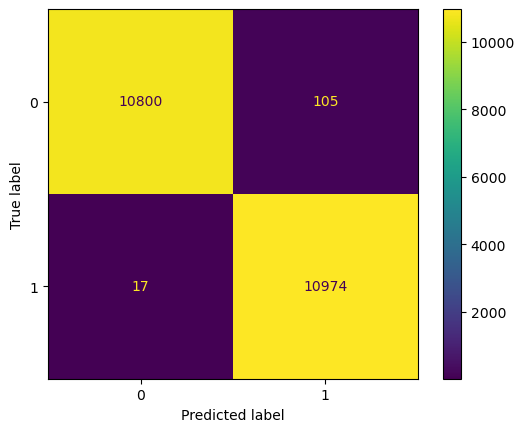

In [27]:
y_pred = tb_catb.predict(X_tb_validate)
print("CATB_TB")
print(classification_report(y_tb_validate, y_pred, digits=4))
print(classification_report(y_tb_validate, y_pred, digits=4), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_ClassReport.txt", mode='w'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_tb_validate, y_pred))
disp.plot()
plt.savefig("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TB_"+"_ConfMatrix.png")

### 2.2.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

In [28]:
# tree = tb_catb.plot_tree(0, catboost.Pool(X_tb_training, y_tb_training, cat_features=get_indexes(), feature_names=list(X_tb_training.columns)))
# tree.save("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TREE/TB_Tree"+".svg")
# display(tree)

## 2.3. Training on Instance-Based Behaviors

### 2.3.1 Training Model

In [29]:
#Training Model
start_time()
ib_catb = setup_model(IB_HYPERPARAMS, "IB")
ib_catb.fit(X_ib_training, y_ib_training, plot=True, eval_set=catboost.Pool(X_ib_validate, label=y_ib_validate, cat_features=get_indexes()), save_snapshot=True, snapshot_interval=60)
end_time("CATB_IB")

#Saving Model as file
ib_catb.save_model("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB.model", format="json")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	learn: 0.4507921	test: 0.4499549	best: 0.4499549 (0)	total: 243ms	remaining: 24s
1:	total: 408ms	remaining: 20s
2:	total: 582ms	remaining: 18.8s
3:	total: 755ms	remaining: 18.1s
4:	total: 916ms	remaining: 17.4s
5:	learn: 0.1009782	test: 0.1004502	best: 0.1004502 (5)	total: 1.08s	remaining: 17s
6:	total: 1.3s	remaining: 17.3s
7:	total: 1.46s	remaining: 16.8s
8:	total: 1.64s	remaining: 16.6s
9:	total: 1.8s	remaining: 16.2s
10:	learn: 0.0480585	test: 0.0476975	best: 0.0476975 (10)	total: 1.97s	remaining: 16s
11:	total: 2.14s	remaining: 15.7s
12:	total: 2.31s	remaining: 15.5s
13:	total: 2.47s	remaining: 15.2s
14:	total: 2.64s	remaining: 15s
15:	learn: 0.0360122	test: 0.0359690	best: 0.0359690 (15)	total: 2.81s	remaining: 14.8s
16:	total: 2.98s	remaining: 14.6s
17:	total: 3.14s	remaining: 14.3s
18:	total: 3.3s	remaining: 14.1s
19:	total: 3.46s	remaining: 13.8s
20:	learn: 0.0318969	test: 0.0323129	best: 0.0323129 (20)	total: 3.63s	remaining: 13.6s
21:	total: 3.79s	remaining: 13.4s
22:	tot

### 2.3.2. Checking Performance

Using the split for validation for a bit of internal checking of performance (i.e., not official)

CATB_IB
              precision    recall  f1-score   support

           0     0.9987    0.9905    0.9946     10905
           1     0.9906    0.9987    0.9947     10991

    accuracy                         0.9946     21896
   macro avg     0.9947    0.9946    0.9946     21896
weighted avg     0.9946    0.9946    0.9946     21896



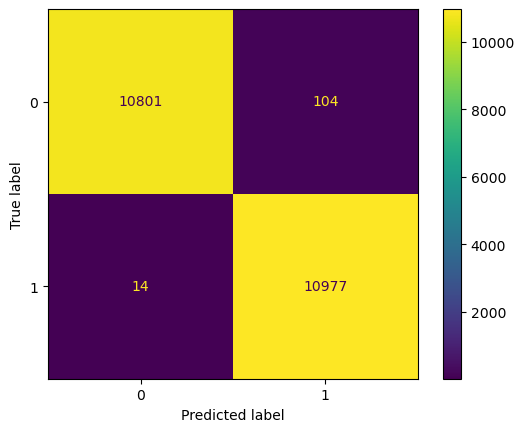

In [30]:
y_pred = ib_catb.predict(X_ib_validate)
print("CATB_IB")
print(classification_report(y_ib_validate, y_pred, digits=4))
print(classification_report(y_ib_validate, y_pred, digits=4), file=open("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_ClassReport.txt", mode='w'))
disp = ConfusionMatrixDisplay(confusion_matrix(y_ib_validate, y_pred))
disp.plot()
plt.savefig("Outputs/CATB/"+MODEL_FILENAME+"_CATB_IB_"+"_ConfMatrix.png")

### 2.3.3. Preview of the Tree

*How can it be a tree if there is no proof of a tree?*

In [31]:
# tree = ib_catb.plot_tree(0, catboost.Pool(X_ib_training, y_ib_training, cat_features=get_indexes(), feature_names=list(X_ib_training.columns)))
# tree.save("Outputs/CATB/"+MODEL_FILENAME+"_CATB_TREE/IB_Tree"+".svg")
# tree

In [32]:
logging("\n")